# Overview

Notebook ini digunakan untuk mengaplikasikan model forecasting pada produk pareto di data

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score
from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
import pickle

from itertools import product

# Importing the Data

In [2]:
df = pd.read_parquet('data/preprocessed/forecast_ready.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379743 entries, 0 to 379742
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   unique_id              379743 non-null  object        
 1   sku_id                 379743 non-null  object        
 2   country                379743 non-null  object        
 3   ds                     379743 non-null  datetime64[ns]
 4   quantity               379743 non-null  float64       
 5   gmv                    379743 non-null  float64       
 6   total_order            379743 non-null  float64       
 7   total_customer         379743 non-null  float64       
 8   price                  379743 non-null  float64       
 9   missing_quantity       379743 non-null  bool          
 10  quantity_count         379743 non-null  int64         
 11  quantity_mean          379743 non-null  float64       
 12  quantity_median        379743 non-null  floa

In [4]:
df.head()

,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10002 | AUSTRALIA,10002,AUSTRALIA,2010-03-01,12.0,10.2,1.0,1.0,0.85,False,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
1,10002 | AUSTRALIA,10002,AUSTRALIA,2010-04-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
2,10002 | AUSTRALIA,10002,AUSTRALIA,2010-05-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
3,10002 | AUSTRALIA,10002,AUSTRALIA,2010-06-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664
4,10002 | AUSTRALIA,10002,AUSTRALIA,2010-07-01,0.0,0.0,0.0,0.0,0.85,True,21,1.714286,0.0,5.737097,0.0,24.0,0.904762,3.34664


In [5]:
df.ds.unique()

<DatetimeArray>
['2010-03-01 00:00:00', '2010-04-01 00:00:00', '2010-05-01 00:00:00',
 '2010-06-01 00:00:00', '2010-07-01 00:00:00', '2010-08-01 00:00:00',
 '2010-09-01 00:00:00', '2010-10-01 00:00:00', '2010-11-01 00:00:00',
 '2010-12-01 00:00:00', '2011-01-01 00:00:00', '2011-02-01 00:00:00',
 '2011-03-01 00:00:00', '2011-04-01 00:00:00', '2011-05-01 00:00:00',
 '2011-06-01 00:00:00', '2011-07-01 00:00:00', '2011-08-01 00:00:00',
 '2011-09-01 00:00:00', '2011-10-01 00:00:00', '2011-11-01 00:00:00',
 '2010-01-01 00:00:00', '2010-02-01 00:00:00', '2009-12-01 00:00:00']
Length: 24, dtype: datetime64[ns]

In [6]:
# Count how many times quantity is 0 for each unique_id to get active sku (quantity > 0)
zero_counts = df[df['quantity'] == 0].groupby(['unique_id']).size().reset_index(name='zero_count')

# Get the (unique_id, sku_id) pairs where zero count > 3
to_drop = zero_counts[zero_counts['zero_count'] > 1][['unique_id']]

In [7]:
to_drop

,unique_id
0,10002 | AUSTRALIA
1,10002 | DENMARK
2,10002 | EIRE
3,10002 | FRANCE
4,10002 | GERMANY
...,...
24142,GIFT_0001_30 | UNITED KINGDOM
24143,GIFT_0001_40 | UNITED KINGDOM
24144,GIFT_0001_50 | UNITED KINGDOM
24145,SP1002 | UNITED KINGDOM


In [8]:
df_filtered = df.merge(to_drop, on=['unique_id'], how='left', indicator=True)
df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
df_filtered


,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
858,10135 | FRANCE,10135,FRANCE,2011-11-01,10.0,12.50,1.0,1.0,1.250000,False,1,10.00,10.0,NaN,10.0,10.0,0.0,NaN
904,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2009-12-01,123.0,174.87,22.0,15.0,1.421707,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
905,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-01-01,48.0,60.00,8.0,8.0,1.250000,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
906,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-02-01,868.0,949.46,17.0,15.0,1.093848,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
907,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-03-01,91.0,115.01,11.0,10.0,1.263846,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379286,C2 | EIRE,C2,EIRE,2011-07-01,10.0,500.00,10.0,2.0,50.000000,False,24,8.25,7.5,4.109903,3.0,18.0,0.0,0.498170
379287,C2 | EIRE,C2,EIRE,2011-08-01,6.0,300.00,6.0,2.0,50.000000,False,24,8.25,7.5,4.109903,3.0,18.0,0.0,0.498170
379288,C2 | EIRE,C2,EIRE,2011-09-01,12.0,600.00,12.0,2.0,50.000000,False,24,8.25,7.5,4.109903,3.0,18.0,0.0,0.498170
379289,C2 | EIRE,C2,EIRE,2011-10-01,10.0,500.00,10.0,2.0,50.000000,False,24,8.25,7.5,4.109903,3.0,18.0,0.0,0.498170


In [9]:
ds_number = df_filtered.groupby(['unique_id']).size().reset_index(name='number of ds')
ds_number

,unique_id,number of ds
0,10135 | FRANCE,1
1,10135 | UNITED KINGDOM,24
2,11001 | NORWAY,1
3,11001 | UNITED KINGDOM,24
4,11001 | UNSPECIFIED,3
...,...,...
4916,90201B | FRANCE,2
4917,90201C | FRANCE,2
4918,90214D | UNITED KINGDOM,24
4919,90214K | UNITED KINGDOM,24


In [10]:
ds_number['number of ds'].sort_values(ascending=False).unique()

array([24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,
        7,  6,  5,  4,  3,  2,  1], dtype=int64)

In [11]:
unique_id_selected = ds_number[ds_number['number of ds']>=18]

In [12]:
unique_id_selected.head()

,unique_id,number of ds
1,10135 | UNITED KINGDOM,24
3,11001 | UNITED KINGDOM,24
6,15034 | UNITED KINGDOM,24
7,15036 | UNITED KINGDOM,24
8,15039 | UNITED KINGDOM,24


In [13]:
# Merge with original df to filter them out
df = df.merge(unique_id_selected['unique_id'], on=['unique_id'], how='right')

In [14]:
df.head()

,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2009-12-01,123.0,174.87,22.0,15.0,1.421707,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
1,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-01-01,48.0,60.00,8.0,8.0,1.250000,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
2,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-02-01,868.0,949.46,17.0,15.0,1.093848,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
3,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-03-01,91.0,115.01,11.0,10.0,1.263846,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
4,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-04-01,70.0,89.87,11.0,7.0,1.283857,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702


In [15]:
df.unique_id.nunique()

1051

# Take Pareto Products

In [16]:
def pareto_by_group(df, group_col, item_col, value_col, threshold=0.8):
    out = (df.groupby([group_col, item_col], as_index=False)[value_col].sum()
             .rename(columns={value_col: 'value'})
             .sort_values([group_col, 'value'], ascending=[True, False]))

    out['cum_value']   = out.groupby(group_col)['value'].cumsum()
    out['group_total'] = out.groupby(group_col)['value'].transform('sum')
    out['cum_pct']     = out['cum_value'] / out['group_total']
    out['pareto_flag'] = out['cum_pct'] <= threshold
    return out

pareto = pareto_by_group(df, 'country', 'sku_id', 'quantity', 0.8)
pareto.head()

,country,sku_id,value,cum_value,group_total,cum_pct,pareto_flag
0,EIRE,21790,2512.0,2512.0,6085.0,0.412818,True
2,EIRE,85123A,2007.0,4519.0,6085.0,0.742646,True
1,EIRE,22423,1368.0,5887.0,6085.0,0.967461,False
3,EIRE,C2,198.0,6085.0,6085.0,1.000000,False
18,FRANCE,22492,3204.0,3204.0,24955.0,0.128391,True


In [17]:
# Take only pareto SKU 
pareto = pareto[pareto.pareto_flag == True]

In [18]:
# merge pareto to main 
df = pd.merge(df, pareto[['country', 'sku_id']], how = 'inner', on=['country', 'sku_id'])

In [19]:
df.unique_id.nunique()

368

# Split into Train and Test Time Series

In [20]:
df = df.sort_values(['unique_id','ds']).reset_index()

In [21]:
horizon = 3
def split(t):
    return pd.Series({
        'train_idx': t.index[:-horizon],
        'val_idx' : t.index[-horizon:-horizon+2],
        'test_idx' : t.index[-horizon+2:]
    })

idxs = (df.groupby(['sku_id','country'], group_keys=False, as_index=False)
          .apply(split, include_groups=False))
train = df.loc[np.concatenate(idxs.train_idx.values)]
val = df.loc[np.concatenate(idxs.val_idx.values)]
test  = df.loc[np.concatenate(idxs.test_idx.values)]

In [22]:
train.head()

,index,unique_id,sku_id,country,ds,quantity,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,0,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2009-12-01,123.0,174.87,22.0,15.0,1.421707,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
1,1,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-01-01,48.0,60.00,8.0,8.0,1.250000,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
2,2,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-02-01,868.0,949.46,17.0,15.0,1.093848,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
3,3,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-03-01,91.0,115.01,11.0,10.0,1.263846,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702
4,4,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2010-04-01,70.0,89.87,11.0,7.0,1.283857,False,24,159.75,73.5,206.189708,13.0,868.0,0.0,1.290702


In [23]:
train = train.drop(columns=['index', 'level_0'], errors='ignore')

In [24]:
val = val.drop(columns=['index', 'level_0'], errors='ignore')
test = test.drop(columns=['index', 'level_0'], errors='ignore')

In [25]:
train.ds.min(), train.ds.max()

(Timestamp('2009-12-01 00:00:00'), Timestamp('2011-08-01 00:00:00'))

In [26]:
val.ds.min(), val.ds.max()

(Timestamp('2011-09-01 00:00:00'), Timestamp('2011-10-01 00:00:00'))

In [27]:
test.ds.min(), test.ds.max()

(Timestamp('2011-11-01 00:00:00'), Timestamp('2011-11-01 00:00:00'))

# Clustering Time Series

In [28]:
train.columns

Index(['unique_id', 'sku_id', 'country', 'ds', 'quantity', 'gmv',
       'total_order', 'total_customer', 'price', 'missing_quantity',
       'quantity_count', 'quantity_mean', 'quantity_median',
       'quantity_std_dev', 'quantity_min', 'quantity_max',
       'missing_quantity_mean', 'quantity_cv'],
      dtype='object')

In [29]:
cluster_features = [
    "quantity_mean", "quantity_median", "quantity_std_dev",
    "quantity_min", "quantity_max", "missing_quantity_mean", "quantity_cv"
]
df_cluster = train.dropna(subset=cluster_features).copy()

In [30]:
df_cluster = df_cluster[['unique_id', "quantity_mean", "quantity_median", "quantity_std_dev",
    "quantity_min", "quantity_max", "missing_quantity_mean", "quantity_cv"]].drop_duplicates()

In [31]:
df_cluster.head()

,unique_id,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv
0,10135 | UNITED KINGDOM,159.750000,73.5,206.189708,13.0,868.0,0.0,1.290702
24,11001 | UNITED KINGDOM,189.291667,98.0,231.932801,17.0,967.0,0.0,1.225267
48,15034 | UNITED KINGDOM,412.666667,210.0,445.266375,62.0,1695.0,0.0,1.078998
72,15036 | UNITED KINGDOM,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519
96,15039 | UNITED KINGDOM,204.625000,134.5,195.198408,11.0,636.0,0.0,0.953932


In [32]:
df_cluster.unique_id.nunique()

368

In [33]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_cluster[cluster_features])

In [34]:


def silhouette_scores(X, k_min=2, k_max=10):
    scores = []
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        score = silhouette_score(X, kmeans.labels_)
        scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(range(k_min, k_max + 1), scores, marker='o')
    plt.title('Silhouette Score per k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


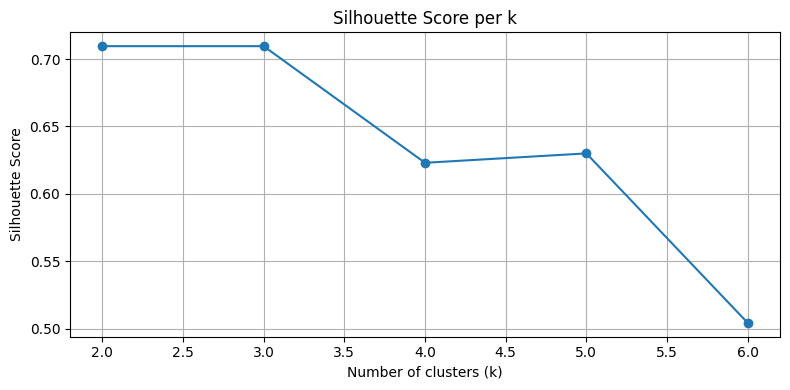

In [35]:
silhouette_scores(X, k_min=2, k_max=6)

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

In [37]:
df_cluster.head()

,unique_id,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
0,10135 | UNITED KINGDOM,159.750000,73.5,206.189708,13.0,868.0,0.0,1.290702,0
24,11001 | UNITED KINGDOM,189.291667,98.0,231.932801,17.0,967.0,0.0,1.225267,0
48,15034 | UNITED KINGDOM,412.666667,210.0,445.266375,62.0,1695.0,0.0,1.078998,0
72,15036 | UNITED KINGDOM,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
96,15039 | UNITED KINGDOM,204.625000,134.5,195.198408,11.0,636.0,0.0,0.953932,0


In [38]:
df_cluster.groupby('cluster').describe().T

cluster                                0            1             2
quantity_mean         count   286.000000    58.000000     24.000000
                      mean    345.936387   332.205593   1847.976987
                      std     215.539615   286.900708    946.176306
                      min      43.750000    36.041667    967.666667
                      25%     198.854167   157.007440   1246.771930
                      50%     257.562500   240.503788   1457.125000
                      75%     436.635417   458.625000   1944.388158
                      max    1138.750000  1389.958333   4168.083333
quantity_median       count   286.000000    58.000000     24.000000
                      mean    277.122378   255.732759   1619.895833
                      std     201.993944   200.849429    927.113156
                      min       9.500000    29.500000    247.500000
                      25%     146.000000   107.625000   1120.500000
                      50%     207.750000   206.750000   1336.000000
                      75%     333.375000   362.500000   1925.000000
                      max    1142.000000   838.000000   3943.000000
quantity_std_dev      count   286.000000    58.000000     24.000000
                      mean    253.541008   301.035699   1139.903721
                      std     187.222765   378.351675    721.543783
                      min      27.206568    24.308666    321.132639
                      25%     135.200192   100.214570    705.158865
                      50%     199.192345   208.559177    896.549058
                      75%     294.633327   337.441896   1370.778889
                      max    1168.844945  2237.803863   3213.988542
quantity_min          count   286.000000    58.000000     24.000000
                      mean     69.111888     0.000000    533.291667
                      std      79.520634     0.000000    419.166925
                      min       1.000000     0.000000     42.000000
                      25%      14.000000     0.000000    340.250000
                      50%      47.000000     0.000000    434.000000
                      75%      86.000000     0.000000    553.000000
                      max     597.000000     0.000000   1450.000000
quantity_max          count   286.000000    58.000000     24.000000
                      mean   1068.097902  1191.120690   5094.250000
                      std     811.236793  1422.821253   3070.514548
                      min     110.000000    90.000000   1875.000000
                      25%     559.250000   359.250000   3019.500000
                      50%     804.500000   780.000000   4110.000000
                      75%    1306.750000  1419.500000   6033.250000
                      max    4993.000000  7633.000000  13859.000000
missing_quantity_mean count   286.000000    58.000000     24.000000
                      mean      0.000000     0.043659      0.000000
                      std       0.000000     0.003223      0.000000
                      min       0.000000     0.041667      0.000000
                      25%       0.000000     0.041667      0.000000
                      50%       0.000000     0.041667      0.000000
                      75%       0.000000     0.045455      0.000000
                      max       0.000000     0.052632      0.000000
quantity_cv           count   286.000000    58.000000     24.000000
                      mean      0.764416     0.822693      0.659431
                      std       0.382925     0.332853      0.448677
                      min       0.310649     0.353697      0.283321
                      25%       0.543935     0.571590      0.410237
                      50%       0.671416     0.732287      0.562341
                      75%       0.871844     0.947790      0.635704
                      max       3.737270     1.800396      2.458406

In [39]:
train = pd.merge(train, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

In [40]:
val = pd.merge(val, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

In [41]:
test = pd.merge(test, df_cluster[['unique_id', 'cluster']], how='left', on='unique_id')

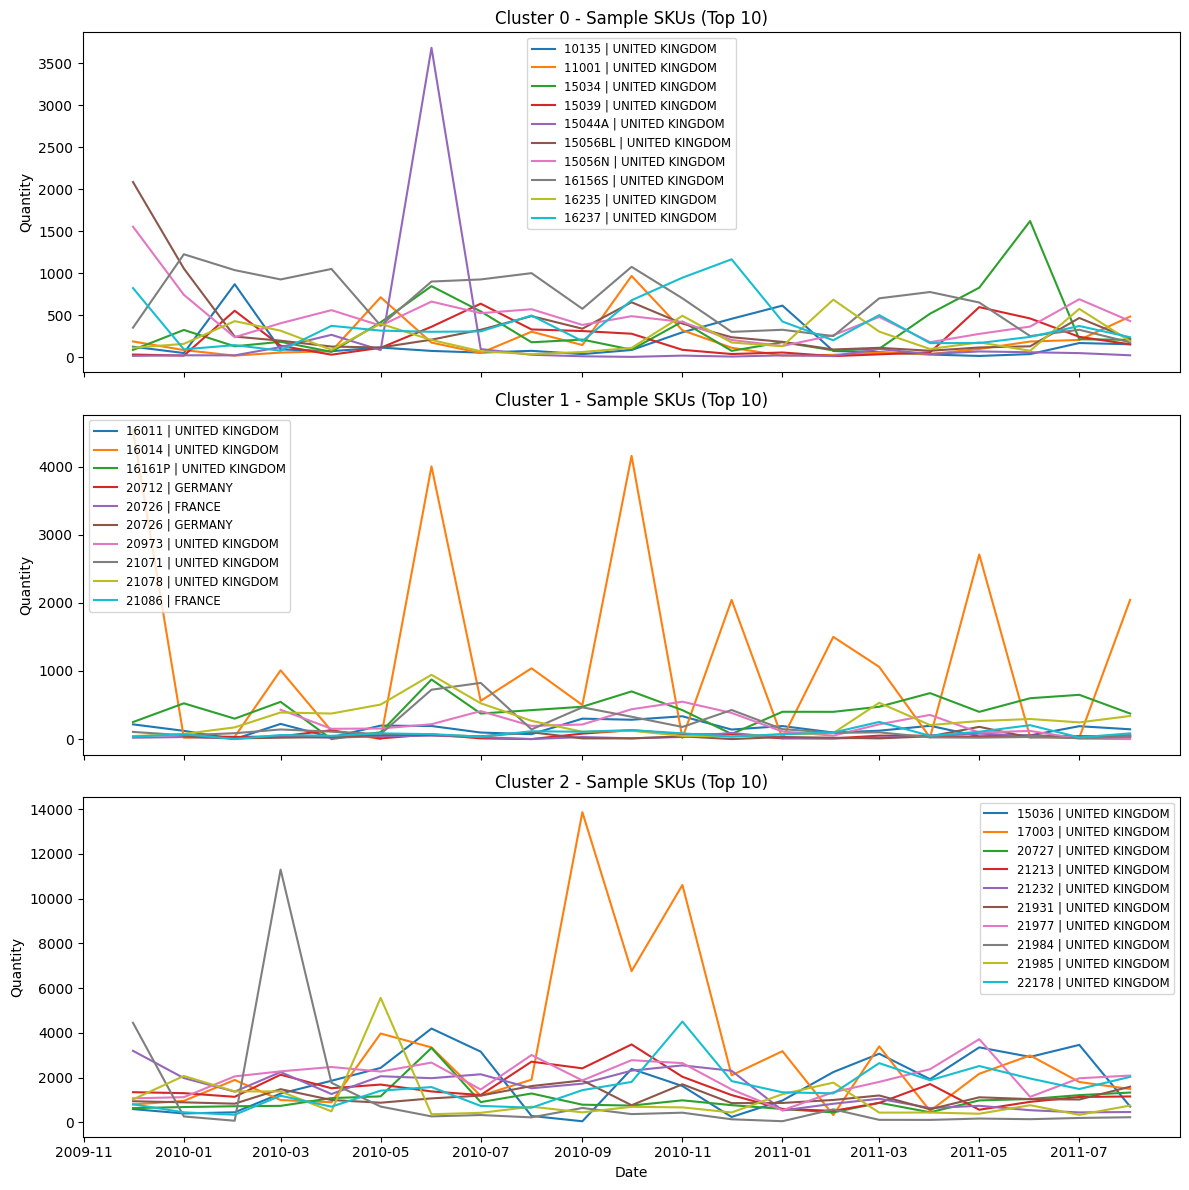

In [42]:



# Get number of clusters
n_clusters = train['cluster'].nunique()
fig, axs = plt.subplots(n_clusters, 1, figsize=(12, 4 * n_clusters), sharex=True)

for i in range(n_clusters):
    ax = axs[i] if n_clusters > 1 else axs
    cluster_df = train[train['cluster'] == i]
    
    # Get first 5 unique SKUs in this cluster
    unique_ids = cluster_df['unique_id'].unique()[:10]

    for uid in unique_ids:
        sku_df = cluster_df[cluster_df['unique_id'] == uid].sort_values('ds')
        ax.plot(sku_df['ds'], sku_df['quantity'], label=uid)

    ax.set_title(f"Cluster {i} - Sample SKUs (Top 10)")
    ax.set_ylabel("Quantity")
    ax.legend(fontsize='small')

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# Training Model

## Random Forest + MLForecast

In [43]:
cluster2 = train[train['cluster'] == 2].copy()

In [44]:
cluster2.rename(columns={'quantity':'y'}, inplace=True)

In [45]:
cluster2.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
63,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2009-12-01,594.0,391.45,29.0,10.0,0.659007,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
64,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-01-01,399.0,283.94,30.0,14.0,0.711629,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
65,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-02-01,451.0,298.35,19.0,13.0,0.661530,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
66,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-03-01,1287.0,857.29,34.0,22.0,0.666115,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
67,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-04-01,1859.0,1283.20,38.0,30.0,0.690264,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2


In [46]:
cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 63 to 7241
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   unique_id              477 non-null    object        
 1   sku_id                 477 non-null    object        
 2   country                477 non-null    object        
 3   ds                     477 non-null    datetime64[ns]
 4   y                      477 non-null    float64       
 5   gmv                    477 non-null    float64       
 6   total_order            477 non-null    float64       
 7   total_customer         477 non-null    float64       
 8   price                  477 non-null    float64       
 9   missing_quantity       477 non-null    bool          
 10  quantity_count         477 non-null    int64         
 11  quantity_mean          477 non-null    float64       
 12  quantity_median        477 non-null    float64       
 13  quantity

In [47]:
cluster2.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
63,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2009-12-01,594.0,391.45,29.0,10.0,0.659007,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
64,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-01-01,399.0,283.94,30.0,14.0,0.711629,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
65,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-02-01,451.0,298.35,19.0,13.0,0.661530,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
66,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-03-01,1287.0,857.29,34.0,22.0,0.666115,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
67,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2010-04-01,1859.0,1283.20,38.0,30.0,0.690264,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2


In [49]:
val.rename(columns={'quantity':'y'}, inplace=True)
test.rename(columns={'quantity':'y'}, inplace=True)

In [50]:
test.head()

,unique_id,sku_id,country,ds,y,gmv,total_order,total_customer,price,missing_quantity,quantity_count,quantity_mean,quantity_median,quantity_std_dev,quantity_min,quantity_max,missing_quantity_mean,quantity_cv,cluster
0,10135 | UNITED KINGDOM,10135,UNITED KINGDOM,2011-11-01,171.0,212.52,21.0,12.0,1.242807,False,24,159.750000,73.5,206.189708,13.0,868.0,0.0,1.290702,0
1,11001 | UNITED KINGDOM,11001,UNITED KINGDOM,2011-11-01,96.0,183.04,12.0,6.0,1.906667,False,24,189.291667,98.0,231.932801,17.0,967.0,0.0,1.225267,0
2,15034 | UNITED KINGDOM,15034,UNITED KINGDOM,2011-11-01,573.0,91.26,23.0,14.0,0.159267,False,24,412.666667,210.0,445.266375,62.0,1695.0,0.0,1.078998,0
3,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2011-11-01,604.0,533.32,42.0,24.0,0.882980,False,24,1659.166667,1455.5,1235.281825,50.0,4193.0,0.0,0.744519,2
4,15039 | UNITED KINGDOM,15039,UNITED KINGDOM,2011-11-01,209.0,304.79,20.0,9.0,1.458325,False,24,204.625000,134.5,195.198408,11.0,636.0,0.0,0.953932,0


In [51]:
val2 = val[val.cluster == 2]
test2 = test[test.cluster == 2]

In [52]:


results = []

param_grid = {
    'n_estimators': [300, 500, 1000],
    'max_depth': [10, 20, 30],  # None = no limit
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 4, 8],
}

for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    rf = RandomForestRegressor(
        n_jobs=-1,
        random_state=42,
        **param_dict
    )

    mforc = MLForecast(
        models={'yhat': rf},
        freq='MS',
        lags=[1, 3],
        date_features=['month', 'quarter'],
        num_threads=1,
        target_transforms=[Differences([1])]
    )

    # Fit model
    mforc.fit(cluster2[['unique_id', 'ds', 'y']].fillna(0), id_col='unique_id', time_col='ds', target_col='y')

    # In-sample prediction (validation data)
    preds_df = mforc.predict(h=2)

    # Merge with actuals
    merged = preds_df.merge(val2, on=['unique_id', 'ds'], how='left')

    # Evaluate
    per_id_mae = merged.groupby('unique_id').apply(
        lambda g: mean_absolute_error(g['y'], g['yhat']),
        include_groups=False
    ).mean()

    per_id_mape = merged.groupby('unique_id').apply(
        lambda g: mean_absolute_percentage_error(g['y'], g['yhat']),
        include_groups=False
    ).mean()


    results.append({
        'params': param_dict,
        'mae': per_id_mae,
        'mape': per_id_mape
    })




Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2}, MAE: 731.3391, MAPE: 103.59%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}, MAE: 666.2246, MAPE: 100.80%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 8}, MAE: 674.4442, MAPE: 107.60%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}, MAE: 694.8909, MAPE: 107.23%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}, MAE: 668.8760, MAPE: 103.32%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}, MAE: 674.4442, MAPE: 107.60%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 2}, MAE: 698.4341, MAPE: 97.13%
Params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 4}, MAE: 696.2031, MAPE: 104.46%
Para

In [53]:
# Sort by MAE, then MAPE
sorted_results = sorted(results, key=lambda x: (x['mae'], x['mape']))

best_result = sorted_results[0]

print("\n✅ Best Parameters Found:")
print(f"Params: {best_result['params']}")
print(f"MAE: {best_result['mae']:.4f}")
print(f"MAPE: {best_result['mape']:.2%}")



✅ Best Parameters Found:
Params: {'n_estimators': 1000, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 4}
MAE: 641.2972
MAPE: 97.60%


In [54]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=4,
    n_jobs=-1,
    random_state=42
)

In [55]:
mforc = MLForecast(
    models={'yhat': rf},
    freq='MS',              # monthly start
    lags=[1, 3],            # lag bulanan
    date_features=['month', 'quarter'],
    num_threads=1,
    target_transforms=[Differences([1])]  # optional
)

In [56]:
# Fit model
mforc.fit(cluster2[['unique_id', 'ds', 'y']].fillna(0), id_col='unique_id', time_col='ds', target_col='y')

MLForecast(models=[yhat], freq=MS, lag_features=['lag1', 'lag3'], date_features=['month', 'quarter'], num_threads=1)

In [57]:
preds = mforc.predict(h=3)

In [58]:
preds

,unique_id,ds,yhat
0,15036 | UNITED KINGDOM,2011-09-01,1496.400464
1,15036 | UNITED KINGDOM,2011-10-01,1627.691676
2,15036 | UNITED KINGDOM,2011-11-01,2036.862492
3,17003 | UNITED KINGDOM,2011-09-01,1812.309220
4,17003 | UNITED KINGDOM,2011-10-01,2374.263007
...,...,...,...
67,85099F | UNITED KINGDOM,2011-10-01,2257.682937
68,85099F | UNITED KINGDOM,2011-11-01,2030.916267
69,85123A | UNITED KINGDOM,2011-09-01,2898.221750
70,85123A | UNITED KINGDOM,2011-10-01,2534.935966


In [59]:
df_union = pd.concat([val2, test2], ignore_index=True)

In [60]:
merged = df_union.merge(preds[['unique_id','ds','yhat']], on=['unique_id','ds'], how='left')

In [61]:
merged[['unique_id', 'sku_id', 'country', 'ds', 'y', 'yhat']].sort_values('unique_id').head()

,unique_id,sku_id,country,ds,y,yhat
0,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2011-09-01,391.0,1496.400464
1,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2011-10-01,1183.0,1627.691676
48,15036 | UNITED KINGDOM,15036,UNITED KINGDOM,2011-11-01,604.0,2036.862492
2,17003 | UNITED KINGDOM,17003,UNITED KINGDOM,2011-09-01,2123.0,1812.309220
3,17003 | UNITED KINGDOM,17003,UNITED KINGDOM,2011-10-01,2400.0,2374.263007


In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Define a function to calculate metrics per group
def calc_metrics(group):
    return pd.Series({
        'MSE': mean_squared_error(group['y'], group['yhat']),
        'MAE': mean_absolute_error(group['y'], group['yhat']),
        'MAPE(%)': mean_absolute_percentage_error(group['y'], group['yhat']) * 100
    })

# Apply per unique_id
metrics_per_id = merged[['unique_id', 'sku_id', 'country', 'ds', 'y', 'yhat']].groupby('unique_id').apply(calc_metrics).reset_index()
metrics_per_id.sort_values('MAPE(%)', ascending=True)


C:\Users\PC\AppData\Local\Temp\ipykernel_13204\2006523718.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_id = merged[['unique_id', 'sku_id', 'country', 'ds', 'y', 'yhat']].groupby('unique_id').apply(calc_metrics).reset_index()


,unique_id,MSE,MAE,MAPE(%)
20,85099B | UNITED KINGDOM,1.352299e+05,318.287856,6.193534
10,22355 | UNITED KINGDOM,1.676433e+04,111.932745,7.678850
21,85099C | UNITED KINGDOM,8.161795e+04,212.912394,14.189222
12,22469 | UNITED KINGDOM,5.107707e+05,520.250713,22.839742
15,84077 | UNITED KINGDOM,9.768112e+06,2147.166456,31.717600
18,84879 | UNITED KINGDOM,1.647924e+06,1146.283671,32.117539
11,22423 | UNITED KINGDOM,7.765088e+04,272.456238,39.000713
14,22616 | UNITED KINGDOM,7.436376e+05,731.648223,41.047820
23,85123A | UNITED KINGDOM,1.034058e+06,958.335784,41.872475
22,85099F | UNITED KINGDOM,5.011039e+05,542.995623,52.097444


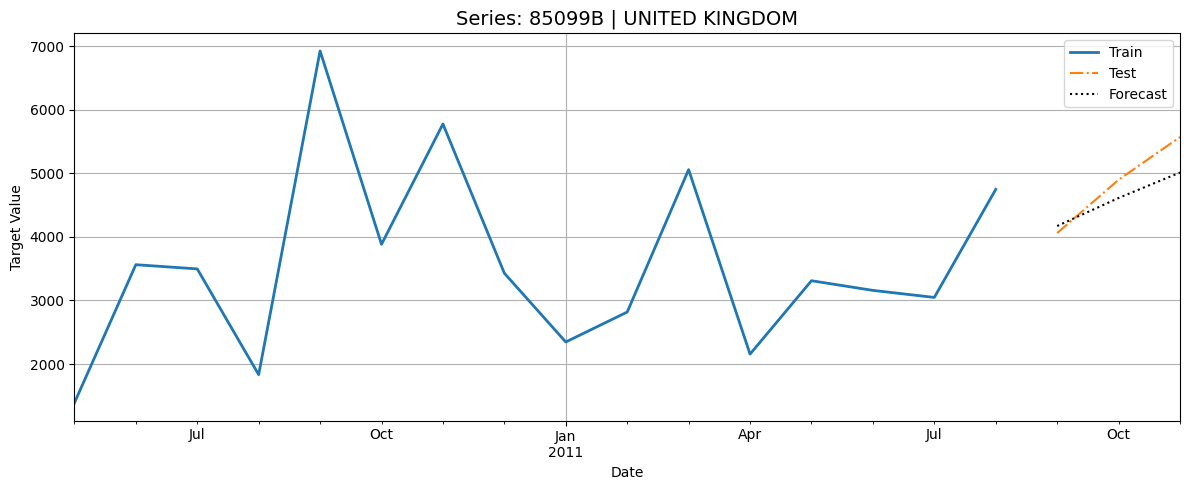

In [63]:


# Sample series
sample_id = '85099B | UNITED KINGDOM'

# Create individual time series
plot_train = cluster2[cluster2.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_test  = merged[merged.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_pred  = merged[merged.unique_id == sample_id][['ds', 'yhat']].set_index('ds')

# Create figure
plt.figure(figsize=(12, 5))
ax = plot_train['y'].plot(label='Train', linewidth=2)

plot_test['y'].plot(ax=ax, label='Test', linestyle='-.')
plot_pred['yhat'].plot(ax=ax, label='Forecast', linestyle=':', color='black')

# Add labels and title
ax.set_title(f'Series: {sample_id}', fontsize=14)
ax.set_ylabel('Target Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


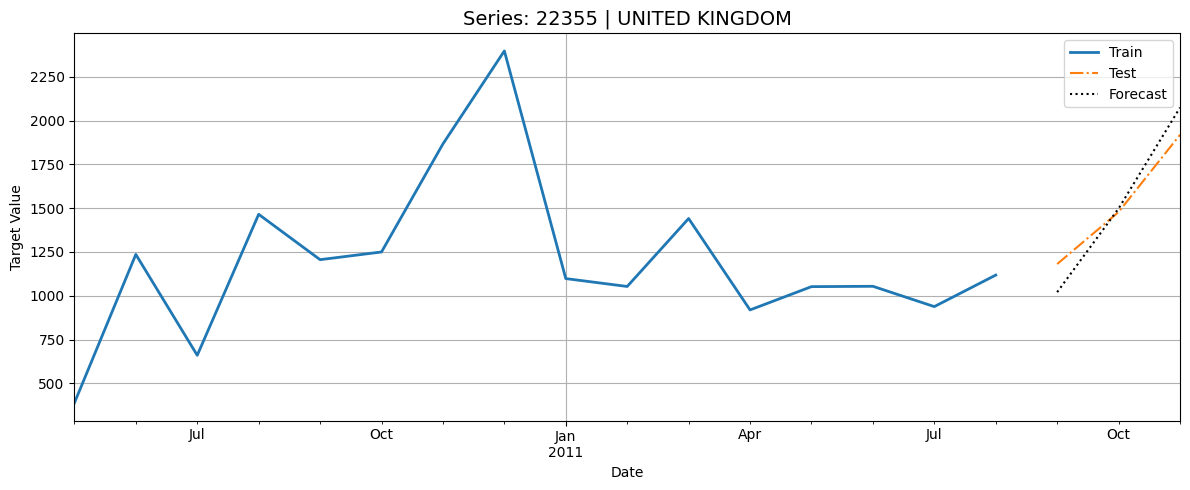

In [64]:


# Sample series
sample_id = '22355 | UNITED KINGDOM'

# Create individual time series
plot_train = cluster2[cluster2.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_test  = merged[merged.unique_id == sample_id][['ds', 'y']].set_index('ds')
plot_pred  = merged[merged.unique_id == sample_id][['ds', 'yhat']].set_index('ds')

# Create figure
plt.figure(figsize=(12, 5))
ax = plot_train['y'].plot(label='Train', linewidth=2)

plot_test['y'].plot(ax=ax, label='Test', linestyle='-.')
plot_pred['yhat'].plot(ax=ax, label='Forecast', linestyle=':', color='black')

# Add labels and title
ax.set_title(f'Series: {sample_id}', fontsize=14)
ax.set_ylabel('Target Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
